[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8312156844406614684
xla_global_id: -1
]
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_encoder (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_17 (Dense)            (None, 256)                  200960    ['input_encoder[0][0]']       
                                                                                                  
 dense_18 (Dense)            (None, 128)                  32896     ['dense_17[0][0]']            
                                                                                                  
 dense_19 (Dense)            (None, 64)                   8

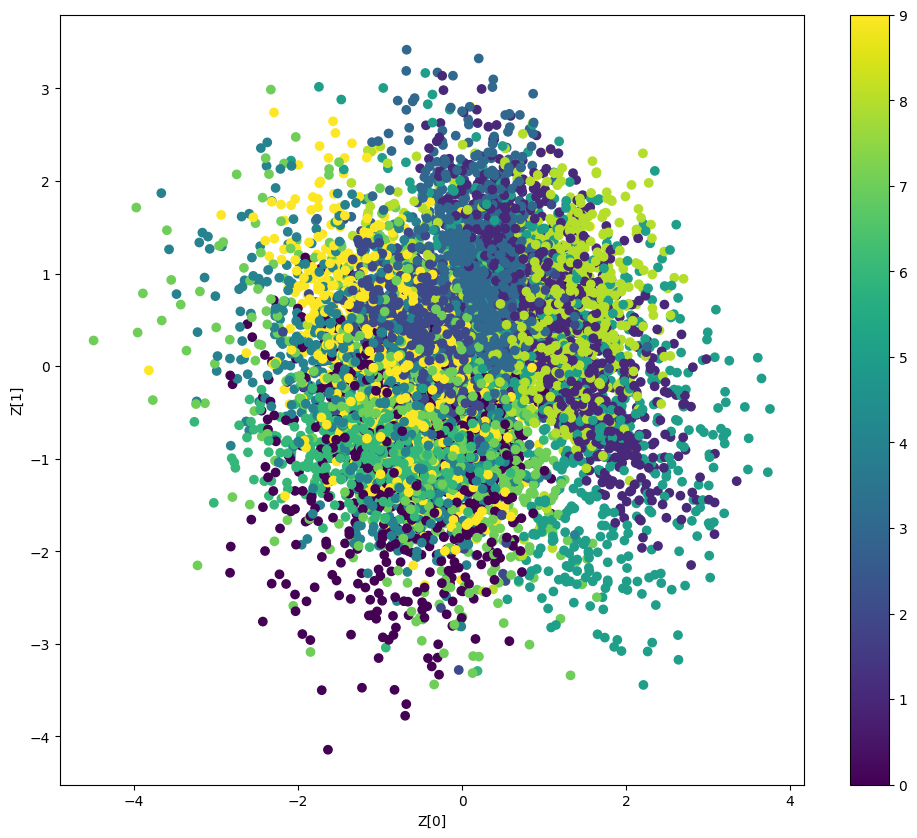

4/4 [==============================] - 0s 4ms/step


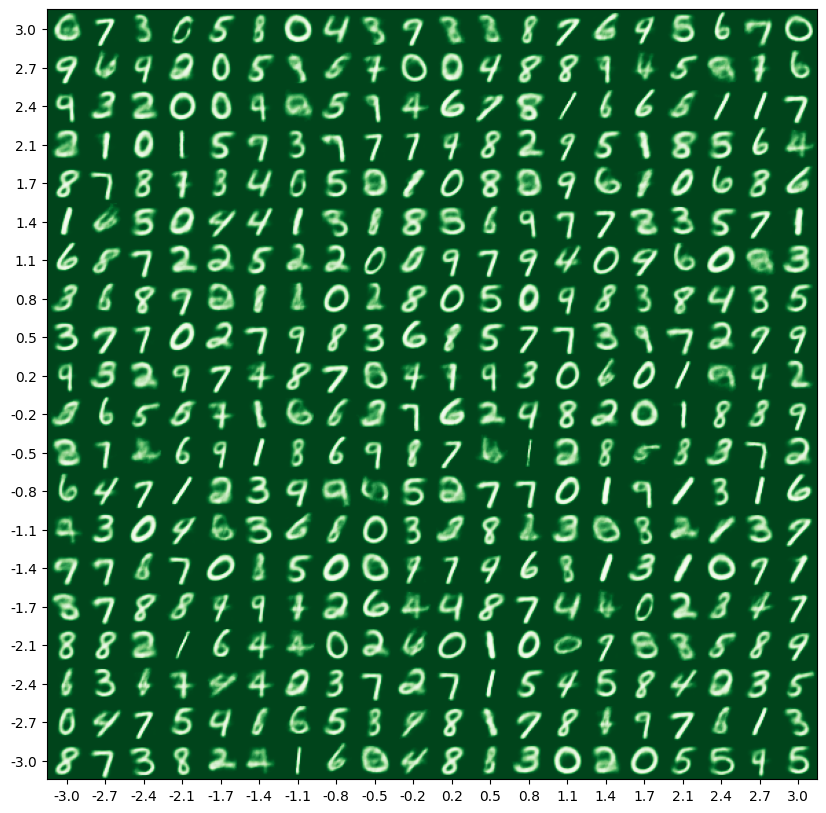

4/4 [==============================] - 0s 3ms/step


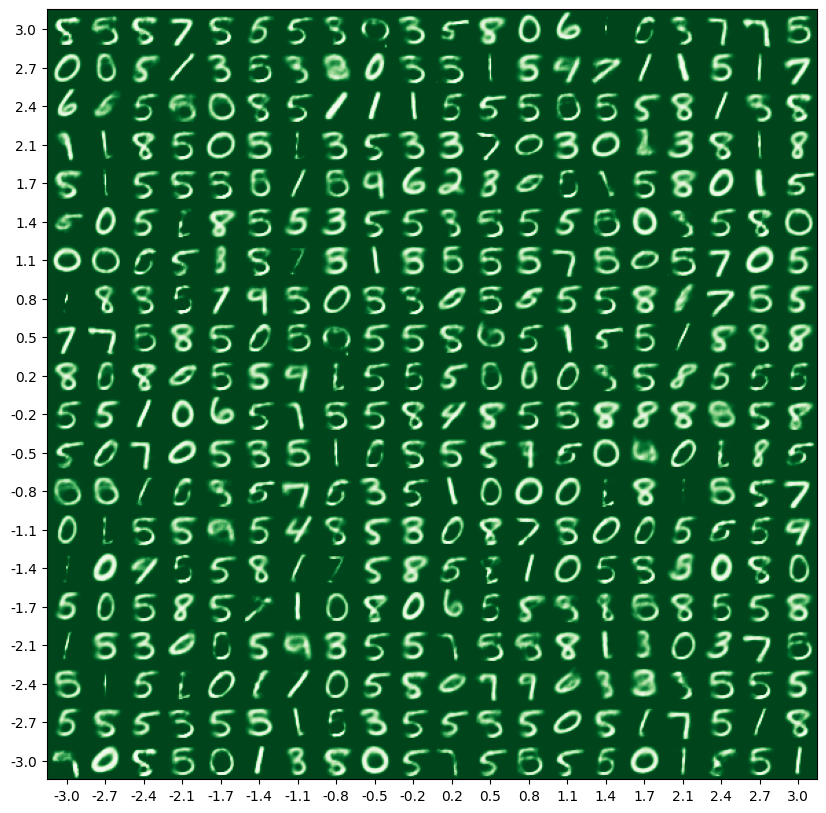

In [4]:
from sklearn.model_selection import GridSearchCV
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import make_scorer
from keras.callbacks import LambdaCallback
import math
import cv2
from tensorflow.python.client import device_lib
import torch
from keras.layers import LeakyReLU
print(device_lib.list_local_devices())
import tensorflow as tf
def orthogonality_regularization(z,l):
    correlation_matrix = K.dot(K.transpose(z), z) / K.cast(K.shape(z)[0], dtype=K.floatx())
    identity_matrix = tf.linalg.diag(tf.ones(K.shape(correlation_matrix)[0], dtype=K.floatx()))
    ortho_penalty = K.sum(K.square(correlation_matrix - identity_matrix))
    ortho_penalty*=0.001
    return ortho_penalty
class vaemodel(object):
    def __init__ (self):
        image_size = 28
        original_dim = image_size * image_size
        self.original_dim = original_dim
        self.input_shape = (original_dim, )
    def latent_sampling(self, args):
        mean, log_stddev = args
        batch = K.shape(mean)[0]
        dim = K.int_shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        return mean + K.exp(0.5 * log_stddev) * epsilon
    def create_model(self, hidden_nodes, latent_nodes, l):
        self.latent_dim = latent_nodes
        encoder_inputs = Input(shape=self.input_shape, name='input_encoder')
        encoder_hidden_1 = Dense(hidden_nodes[0], activation=LeakyReLU())(encoder_inputs)
        encoder_hidden_2 = Dense(hidden_nodes[1], activation=LeakyReLU())(encoder_hidden_1)
        encoder_hidden_3 = Dense(hidden_nodes[2], activation=LeakyReLU())(encoder_hidden_2)

        z_mean = Dense(latent_nodes, name='z_mean')(encoder_hidden_3)
        z_log_var = Dense(latent_nodes, name='z_log_var')(encoder_hidden_3)

        z = Lambda(self.latent_sampling, output_shape=(latent_nodes,), name='z')([z_mean, z_log_var])

        encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
        encoder.summary()

        latent_encoder_inputs = Input(shape=(latent_nodes,), name='latent_sampling')
        decoder_hidden_1 = Dense(hidden_nodes[2], activation='relu')(latent_encoder_inputs)
        decoder_hidden_2 = Dense(hidden_nodes[1], activation='relu')(decoder_hidden_1)
        decoder_hidden_3 = Dense(hidden_nodes[0], activation='relu')(decoder_hidden_2)
        decoder_outputs = Dense(self.original_dim, activation='sigmoid')(decoder_hidden_3)

        decoder = Model(latent_encoder_inputs, decoder_outputs)
        decoder.summary()

        model_outputs = decoder(encoder(encoder_inputs)[2])
        vae = Model(encoder_inputs, model_outputs, name='vae_mlp')

        reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)
        reconstruction_loss *= self.original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae_loss += orthogonality_regularization(z, l)
        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')
        
        return vae, encoder, decoder
    def plotlatent(self,encoder,data,test,batch_size):
        z_test, _, _ = encoder.predict(data, batch_size=batch_size)
        plt.figure(figsize=(12, 10))
        plt.scatter(z_test[:, 0], z_test[:, 1], c=test)
        plt.colorbar()
        plt.xlabel("Z[0]")
        plt.ylabel("Z[1]")
        plt.savefig("VAE")
        plt.show()
    def plotoutput(self,decoder,latent_dim,batch_size):
        n = 20
        digit_num = 28
        figure = np.zeros((digit_num * n, digit_num * n))
        axis_x = np.linspace(-3, 3, n)
        axis_y = np.linspace(-3, 3, n)[::-1]
        for i, yi in enumerate(axis_y):
            for j, xi in enumerate(axis_x):
                if(latent_dim == 2):
                    latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
                else:
                    latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
                input_decoded = decoder.predict(latent_sample)
                digit = input_decoded[0].reshape(digit_num, digit_num)
                figure[i * digit_num: (i + 1) * digit_num,
                    j * digit_num: (j + 1) * digit_num] = digit

        plt.figure(figsize=(10, 10))
        i_range = digit_num // 2
        j_range = (n - 1) * digit_num + i_range + 1
        pixel_range = np.arange(i_range, j_range, digit_num)
        sample_range_x = np.round(axis_x, 1)
        sample_range_y = np.round(axis_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.imshow(figure, cmap='Greens_r')
        plt.savefig("VAE_Output_blur")
        plt.show()
    def plotoutputgauss(self,decoder,latent_dim,batch_size):
        n = 20
        digit_num = 28
        figure = np.zeros((digit_num * n, digit_num * n))
        axis_x = np.linspace(-3, 3, n)
        axis_y = np.linspace(-3, 3, n)[::-1]
        for i, yi in enumerate(axis_y):
            for j, xi in enumerate(axis_x):
                if(latent_dim == 2):
                    latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
                else:
                    latent_sample = np.random.normal(1,2,size=[batch_size, latent_dim])
                input_decoded = decoder.predict(latent_sample)
                digit = input_decoded[0].reshape(digit_num, digit_num)
                figure[i * digit_num: (i + 1) * digit_num,
                    j * digit_num: (j + 1) * digit_num] = digit

        plt.figure(figsize=(10, 10))
        i_range = digit_num // 2
        j_range = (n - 1) * digit_num + i_range + 1
        pixel_range = np.arange(i_range, j_range, digit_num)
        sample_range_x = np.round(axis_x, 1)
        sample_range_y = np.round(axis_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.imshow(figure, cmap='Greens_r')
        plt.savefig("VAE_Output_gauss")
        plt.show()

(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()

def apply_gaussian_blur(images):
    blurred_images = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0) 
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

x_train_data_blurred = apply_gaussian_blur(x_train_data)
x_test_data_blurred = apply_gaussian_blur(x_test_data)
image_size = x_train_data.shape[1]
original_dim = image_size * image_size
x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])
x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255
input_shape = (original_dim, )
hdim = [256,128,64]
latent_dim = 3
epochs = 40
vaem = vaemodel()
modelk, encoder, decoder= vaem.create_model(hdim, latent_dim,0)
trained_model = modelk.fit(x_train_data, epochs=epochs, batch_size=128, validation_data=(x_test_data, None))
vaem.plotlatent(encoder, x_test_data, y_test_data, 128)
vaem.plotoutput(decoder, latent_dim, 128)
vaem.plotoutputgauss(decoder,latent_dim,128)
